# Layer-wise Federated Self-Supervised Learning (LW-FedSSL)

## Academic Project - IoT Federated Learning

This notebook demonstrates a comparison between Layer-wise Federated Self-Supervised Learning (LW-FedSSL) and traditional Federated Self-Supervised Learning (FedSSL) on the CIFAR-10 dataset.

**Key Features:**
- LW-FedSSL: Layer-by-layer progressive training with selective parameter updates
- FedSSL: Full model training and aggregation
- Comparison of communication costs, computational FLOPs, and accuracy
- Self-supervised learning using SimCLR-style contrastive loss

In [1]:
# Install required libraries
%pip install ptflops

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy, math
import matplotlib.pyplot as plt
import numpy as np

from ptflops import get_model_complexity_info

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using device: cpu


## Dataset Preparation (CIFAR-10 split into 2 clients)

In [2]:
# Base transforms
transform_base = transforms.Compose([transforms.ToTensor()])

# SSL augmentations (SimCLR style)
ssl_aug = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor()
])

# Load CIFAR-10
train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_base)
test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_base)

# Split train dataset into 2 clients (simulating federated setup)
n = len(train_ds)
c1 = n // 2
c2 = n - c1
client1_ds, client2_ds = random_split(train_ds, [c1, c2])

BATCH = 128
client1_loader = DataLoader(client1_ds, batch_size=BATCH, shuffle=True)
client2_loader = DataLoader(client2_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

print(f"Client 1 dataset size: {len(client1_ds)}")
print(f"Client 2 dataset size: {len(client2_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Client 1 dataset size: 25000
Client 2 dataset size: 25000
Test dataset size: 10000


## Model Definition (Tiny CNN + Projection Heads)

The model supports training at different depths (1, 2, or 3 layers) with corresponding projection heads for self-supervised learning.

In [3]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(3, 32, 3, padding=1),   # Layer 1
            nn.Conv2d(32, 64, 3, padding=1),  # Layer 2
            nn.Conv2d(64, 128, 3, padding=1)  # Layer 3
        ])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Different projection heads for different depths
        self.proj_heads = nn.ModuleDict({
            '1': nn.Sequential(
                nn.Flatten(),
                nn.Linear(32, 128),   # depth 1: 32 features -> 128
                nn.ReLU(),
                nn.Linear(128, 128)
            ),
            '2': nn.Sequential(
                nn.Flatten(),
                nn.Linear(64, 128),   # depth 2: 64 features -> 128
                nn.ReLU(),
                nn.Linear(128, 128)
            ),
            '3': nn.Sequential(
                nn.Flatten(),
                nn.Linear(128, 256),  # depth 3: 128 features -> 256 -> 128
                nn.ReLU(),
                nn.Linear(256, 128)
            )
        })
        
    def forward(self, x, depth):
        for i in range(depth):
            x = F.relu(self.layers[i](x))
        x = self.pool(x)
        return self.proj_heads[str(depth)](x)

# Test model initialization
model = TinyCNN()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Model architecture:")
for name, module in model.named_children():
    print(f"  {name}: {module}")

Model parameters: 204,736
Model architecture:
  layers: ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
  pool: AdaptiveAvgPool2d(output_size=(1, 1))
  proj_heads: ModuleDict(
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
)


## Utility Functions

Functions for parameter freezing, SSL loss computation, and resource monitoring.

In [4]:
def freeze_old_layers(model, active_layer_idx):
    """Freeze all layers except the active one for LW-FedSSL"""
    for i, layer in enumerate(model.layers):
        for p in layer.parameters():
            p.requires_grad = (i == active_layer_idx)
    # Always allow gradients for all projection heads
    for proj_head in model.proj_heads.values():
        for p in proj_head.parameters():
            p.requires_grad = True

def simclr_nt_xent(z1, z2, tau=0.5):
    """SimCLR NT-Xent (Normalized Temperature-scaled Cross Entropy) loss"""
    z1, z2 = F.normalize(z1, dim=1), F.normalize(z2, dim=1)
    logits = torch.mm(z1, z2.t()) / tau
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)

def ssl_batch_augment(batch_images):
    """Apply SSL augmentations to create two views of each image"""
    return (
        torch.stack([ssl_aug(transforms.ToPILImage()(img)) for img in batch_images]),
        torch.stack([ssl_aug(transforms.ToPILImage()(img)) for img in batch_images])
    )

# FLOPs computation helper
class DepthWrapper(nn.Module):
    def __init__(self, base_model, depth):
        super().__init__()
        self.base = base_model
        self.depth = depth
    def forward(self, x):
        return self.base(x, depth=self.depth)

def compute_forward_flops(model, depth, input_res=(3, 32, 32)):
    """Compute forward pass FLOPs for given depth"""
    wrapper = DepthWrapper(model, depth).to(device)
    macs, _ = get_model_complexity_info(wrapper, input_res, as_strings=False, print_per_layer_stat=False)
    return macs / 1e9  # GFLOPs

def get_param_size_bytes(layer):
    """Get parameter size in bytes for a layer"""
    return sum(p.numel() * p.element_size() for p in layer.parameters())

## Client Training Functions

### LW-FedSSL: Layer-wise training with selective parameter updates
### FedSSL: Full model training and aggregation

In [5]:
BACKWARD_RATIO = 2.0  # Approximate cost of backward pass vs forward pass

def client_train_lw_fedssl(model, dataloader, stage_depth, local_epochs=5):
    """LW-FedSSL: Train only the active layer while keeping others frozen"""
    active_idx = stage_depth - 1
    model_local = copy.deepcopy(model).to(device)
    freeze_old_layers(model_local, active_idx)
    
    # Only optimize parameters that require gradients
    opt = optim.Adam(filter(lambda p: p.requires_grad, model_local.parameters()), lr=1e-3)

    for epoch in range(local_epochs):
        total_loss = 0
        num_batches = 0
        
        for xb, _ in dataloader:
            # Create two augmented views for contrastive learning
            x1, x2 = ssl_batch_augment(xb)
            x1, x2 = x1.to(device), x2.to(device)
            
            # Forward pass through the network up to current depth
            z1, z2 = model_local(x1, depth=stage_depth), model_local(x2, depth=stage_depth)
            
            # Contrastive loss
            loss = simclr_nt_xent(z1, z2)
            
            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        if (epoch + 1) % 2 == 0:
            print(f"Stage {stage_depth}, Epoch {epoch+1}, Avg Loss: {total_loss/num_batches:.4f}")

    # Compute computational cost (FLOPs)
    fwd_all = compute_forward_flops(model_local, depth=stage_depth)
    fwd_active = compute_forward_flops(model_local, depth=1)  # Approximation
    flops = fwd_all + BACKWARD_RATIO * fwd_active

    # Return only the trained layer's parameters
    return {k: v.cpu() for k, v in model_local.layers[active_idx].state_dict().items()}, flops

def client_train_fedssl(model, dataloader, local_epochs=5):
    """FedSSL: Train the entire model"""
    model_local = copy.deepcopy(model).to(device)
    
    # Enable gradients for all parameters
    for p in model_local.parameters():
        p.requires_grad = True
    
    opt = optim.Adam(model_local.parameters(), lr=1e-3)

    for epoch in range(local_epochs):
        total_loss = 0
        num_batches = 0
        
        for xb, _ in dataloader:
            # Create two augmented views
            x1, x2 = ssl_batch_augment(xb)
            x1, x2 = x1.to(device), x2.to(device)
            
            # Forward pass through full model (depth=3)
            z1, z2 = model_local(x1, depth=3), model_local(x2, depth=3)
            
            # Contrastive loss
            loss = simclr_nt_xent(z1, z2)
            
            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            total_loss += loss.item()
            num_batches += 1
            
        if (epoch + 1) % 2 == 0:
            print(f"FedSSL Epoch {epoch+1}, Avg Loss: {total_loss/num_batches:.4f}")

    # Compute computational cost
    fwd_all = compute_forward_flops(model_local, depth=3)
    flops = fwd_all * (1 + BACKWARD_RATIO)
    
    # Return all model parameters
    return {k: v.cpu() for k, v in model_local.state_dict().items()}, flops

## Server Aggregation Functions

Functions to aggregate model updates from multiple clients.

In [6]:
def aggregate_layer_dicts(dicts):
    """Aggregate layer parameters from multiple clients (for LW-FedSSL)"""
    agg = {}
    for k in dicts[0].keys():
        agg[k] = torch.mean(torch.stack([d[k].float() for d in dicts]), dim=0)
    return agg

def aggregate_full_models(dicts):
    """Aggregate full model parameters from multiple clients (for FedSSL)"""
    agg = {}
    for k in dicts[0].keys():
        agg[k] = torch.mean(torch.stack([d[k].float() for d in dicts]), dim=0)
    return agg

## Main Training Loops

### LW-FedSSL: Progressive layer-by-layer federated training
### FedSSL: Traditional federated learning with full model updates

In [7]:
def run_lw_fedssl():
    """Run Layer-wise Federated Self-Supervised Learning"""
    model = TinyCNN().to(device)
    comms, flops = [], []
    
    num_rounds = 8  # Number of federated rounds per stage
    print(f"Running LW-FedSSL with {num_rounds} rounds per stage...")
    
    # Train each layer progressively
    for stage in range(1, 4):  # 3 layers
        print(f"\n=== Training Stage {stage} ===")        
        
        for round_num in range(num_rounds):
            print(f"Round {round_num + 1}/{num_rounds}")
            
            # Client training
            u1, f1 = client_train_lw_fedssl(model, client1_loader, stage, local_epochs=3)
            u2, f2 = client_train_lw_fedssl(model, client2_loader, stage, local_epochs=3)
            
            # Server aggregation
            agg = aggregate_layer_dicts([u1, u2])
            model.layers[stage-1].load_state_dict(agg)
            
            # Track communication cost (only for the trained layer)
            size_MB = get_param_size_bytes(model.layers[stage-1]) * 2 / (1024**2)  # Upload + Download
            comms.append(size_MB)
            flops.append((f1 + f2) / 2)
    
    return model, sum(comms), np.mean(flops)

def run_fedssl():
    """Run Traditional Federated Self-Supervised Learning"""
    model = TinyCNN().to(device)
    comms, flops = [], []
    
    num_rounds = 24  # Total rounds (equivalent to 8 rounds × 3 stages)
    print(f"Running FedSSL for {num_rounds} rounds...")
    
    for round_num in range(num_rounds):
        print(f"Round {round_num + 1}/{num_rounds}")
        
        # Client training
        u1, f1 = client_train_fedssl(model, client1_loader, local_epochs=3)
        u2, f2 = client_train_fedssl(model, client2_loader, local_epochs=3)
        
        # Server aggregation
        agg = aggregate_full_models([u1, u2])
        model.load_state_dict(agg)
        
        # Track communication cost (entire model)
        size_MB = sum(p.numel() * p.element_size() for p in model.parameters()) * 2 / (1024**2)
        comms.append(size_MB)
        flops.append((f1 + f2) / 2)
    
    return model, sum(comms), np.mean(flops)

## Linear Probe Evaluation

Evaluate the quality of learned representations using a linear classifier.

In [8]:
class LinearProbe(nn.Module):
    """Linear classifier for evaluating learned representations"""
    def __init__(self, encoder):
        super().__init__()
        self.enc = encoder
        self.fc = nn.Linear(128, 10)  # CIFAR-10 has 10 classes
    
    def forward(self, x):
        with torch.no_grad():
            z = self.enc(x, depth=3)  # Use full depth representation
        return self.fc(z)

def linear_probe_evaluation(encoder, train_loader, test_loader, epochs=15):
    """Evaluate encoder using linear probing"""
    probe = LinearProbe(encoder).to(device)
    opt = optim.Adam(probe.fc.parameters(), lr=1e-3)
    
    print(f"Training linear probe for {epochs} epochs...")
    
    # Training phase
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = probe(xb)
            loss = F.cross_entropy(logits, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"Probe Epoch {epoch+1}, Avg Loss: {total_loss/num_batches:.4f}")
    
    # Evaluation phase
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = probe(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    
    return 100 * correct / total

## Training Execution

Run both LW-FedSSL and FedSSL training procedures.

In [9]:
print("=" * 80)
print("STARTING FEDERATED SELF-SUPERVISED LEARNING COMPARISON")
print("=" * 80)

# Train LW-FedSSL
print("\n🚀 Training LW-FedSSL...")
lw_model, lw_comm, lw_flops = run_lw_fedssl()

# Train FedSSL  
print("\n🚀 Training FedSSL...")
fed_model, fed_comm, fed_flops = run_fedssl()

print("\n✅ Training completed for both methods!")

STARTING FEDERATED SELF-SUPERVISED LEARNING COMPARISON

🚀 Training LW-FedSSL...
Running LW-FedSSL with 8 rounds per stage...

=== Training Stage 1 ===
Round 1/8
Stage 1, Epoch 2, Avg Loss: 3.9221
Stage 1, Epoch 2, Avg Loss: 3.9277
Round 2/8
Stage 1, Epoch 2, Avg Loss: 3.8708
Stage 1, Epoch 2, Avg Loss: 3.8841
Round 3/8
Stage 1, Epoch 2, Avg Loss: 3.8356
Stage 1, Epoch 2, Avg Loss: 3.8392
Round 4/8
Stage 1, Epoch 2, Avg Loss: 3.8035
Stage 1, Epoch 2, Avg Loss: 3.8077
Round 5/8
Stage 1, Epoch 2, Avg Loss: 3.7877
Stage 1, Epoch 2, Avg Loss: 3.7895
Round 6/8
Stage 1, Epoch 2, Avg Loss: 3.7807
Stage 1, Epoch 2, Avg Loss: 3.7829
Round 7/8
Stage 1, Epoch 2, Avg Loss: 3.7726
Stage 1, Epoch 2, Avg Loss: 3.7704
Round 8/8
Stage 1, Epoch 2, Avg Loss: 3.7662
Stage 1, Epoch 2, Avg Loss: 3.7648

=== Training Stage 2 ===
Round 1/8
Stage 2, Epoch 2, Avg Loss: 3.7196
Stage 2, Epoch 2, Avg Loss: 3.7118
Round 2/8
Stage 2, Epoch 2, Avg Loss: 3.6794
Stage 2, Epoch 2, Avg Loss: 3.6777
Round 3/8
Stage 2, Epoc

## Model Evaluation

Evaluate both trained models using linear probing.

In [10]:
print("\n" + "=" * 60)
print("EVALUATING TRAINED MODELS")
print("=" * 60)

# Evaluate LW-FedSSL
print("\n📊 Evaluating LW-FedSSL model...")
lw_acc = linear_probe_evaluation(lw_model, DataLoader(client1_ds, batch_size=128), test_loader, epochs=15)

# Evaluate FedSSL
print("\n📊 Evaluating FedSSL model...")
fed_acc = linear_probe_evaluation(fed_model, DataLoader(client1_ds, batch_size=128), test_loader, epochs=15)

print("\n✅ Evaluation completed!")
print(f"\nLW-FedSSL Accuracy: {lw_acc:.2f}%")
print(f"FedSSL Accuracy:    {fed_acc:.2f}%")


EVALUATING TRAINED MODELS

📊 Evaluating LW-FedSSL model...
Training linear probe for 15 epochs...
Probe Epoch 5, Avg Loss: 1.9730
Probe Epoch 5, Avg Loss: 1.9730
Probe Epoch 10, Avg Loss: 1.8702
Probe Epoch 10, Avg Loss: 1.8702
Probe Epoch 15, Avg Loss: 1.8162
Probe Epoch 15, Avg Loss: 1.8162

📊 Evaluating FedSSL model...
Training linear probe for 15 epochs...

📊 Evaluating FedSSL model...
Training linear probe for 15 epochs...
Probe Epoch 5, Avg Loss: 1.7033
Probe Epoch 5, Avg Loss: 1.7033
Probe Epoch 10, Avg Loss: 1.6701
Probe Epoch 10, Avg Loss: 1.6701
Probe Epoch 15, Avg Loss: 1.6601
Probe Epoch 15, Avg Loss: 1.6601

✅ Evaluation completed!

LW-FedSSL Accuracy: 35.23%
FedSSL Accuracy:    39.14%

✅ Evaluation completed!

LW-FedSSL Accuracy: 35.23%
FedSSL Accuracy:    39.14%


## Results and Analysis

Compare the performance, communication costs, and computational requirements.

In [11]:
print("\n" + "=" * 80)
print("COMPREHENSIVE RESULTS ANALYSIS")
print("=" * 80)

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   LW-FedSSL: Communication={lw_comm:.2f} MB, FLOPs={lw_flops:.3f} G/sample, Accuracy={lw_acc:.2f}%")
print(f"   FedSSL:    Communication={fed_comm:.2f} MB, FLOPs={fed_flops:.3f} G/sample, Accuracy={fed_acc:.2f}%")

print(f"\n💡 EFFICIENCY ANALYSIS:")
comm_reduction = (1 - lw_comm/fed_comm) * 100
flops_reduction = (1 - lw_flops/fed_flops) * 100
acc_diff = lw_acc - fed_acc

print(f"   Communication Reduction: {comm_reduction:.1f}%")
print(f"   FLOPs Reduction: {flops_reduction:.1f}%")
print(f"   Accuracy Difference: {acc_diff:+.2f}%")

print(f"\n🎯 KEY INSIGHTS:")
if comm_reduction > 0:
    print(f"   ✅ LW-FedSSL reduces communication overhead by {comm_reduction:.1f}%")
else:
    print(f"   ❌ LW-FedSSL increases communication overhead by {-comm_reduction:.1f}%")

if flops_reduction > 0:
    print(f"   ✅ LW-FedSSL reduces computational cost by {flops_reduction:.1f}%")
else:
    print(f"   ❌ LW-FedSSL increases computational cost by {-flops_reduction:.1f}%")

if abs(acc_diff) < 2.0:
    print(f"   ✅ Both methods achieve comparable accuracy (difference: {acc_diff:+.2f}%)")
elif acc_diff > 0:
    print(f"   ✅ LW-FedSSL achieves {acc_diff:.2f}% higher accuracy")
else:
    print(f"   ⚠️  LW-FedSSL achieves {-acc_diff:.2f}% lower accuracy")


COMPREHENSIVE RESULTS ANALYSIS

📈 PERFORMANCE METRICS:
   LW-FedSSL: Communication=5.69 MB, FLOPs=0.041 G/sample, Accuracy=35.23%
   FedSSL:    Communication=37.49 MB, FLOPs=0.288 G/sample, Accuracy=39.14%

💡 EFFICIENCY ANALYSIS:
   Communication Reduction: 84.8%
   FLOPs Reduction: 85.7%
   Accuracy Difference: -3.91%

🎯 KEY INSIGHTS:
   ✅ LW-FedSSL reduces communication overhead by 84.8%
   ✅ LW-FedSSL reduces computational cost by 85.7%
   ⚠️  LW-FedSSL achieves 3.91% lower accuracy


## Visualization

Create comprehensive visualizations of the comparison results.

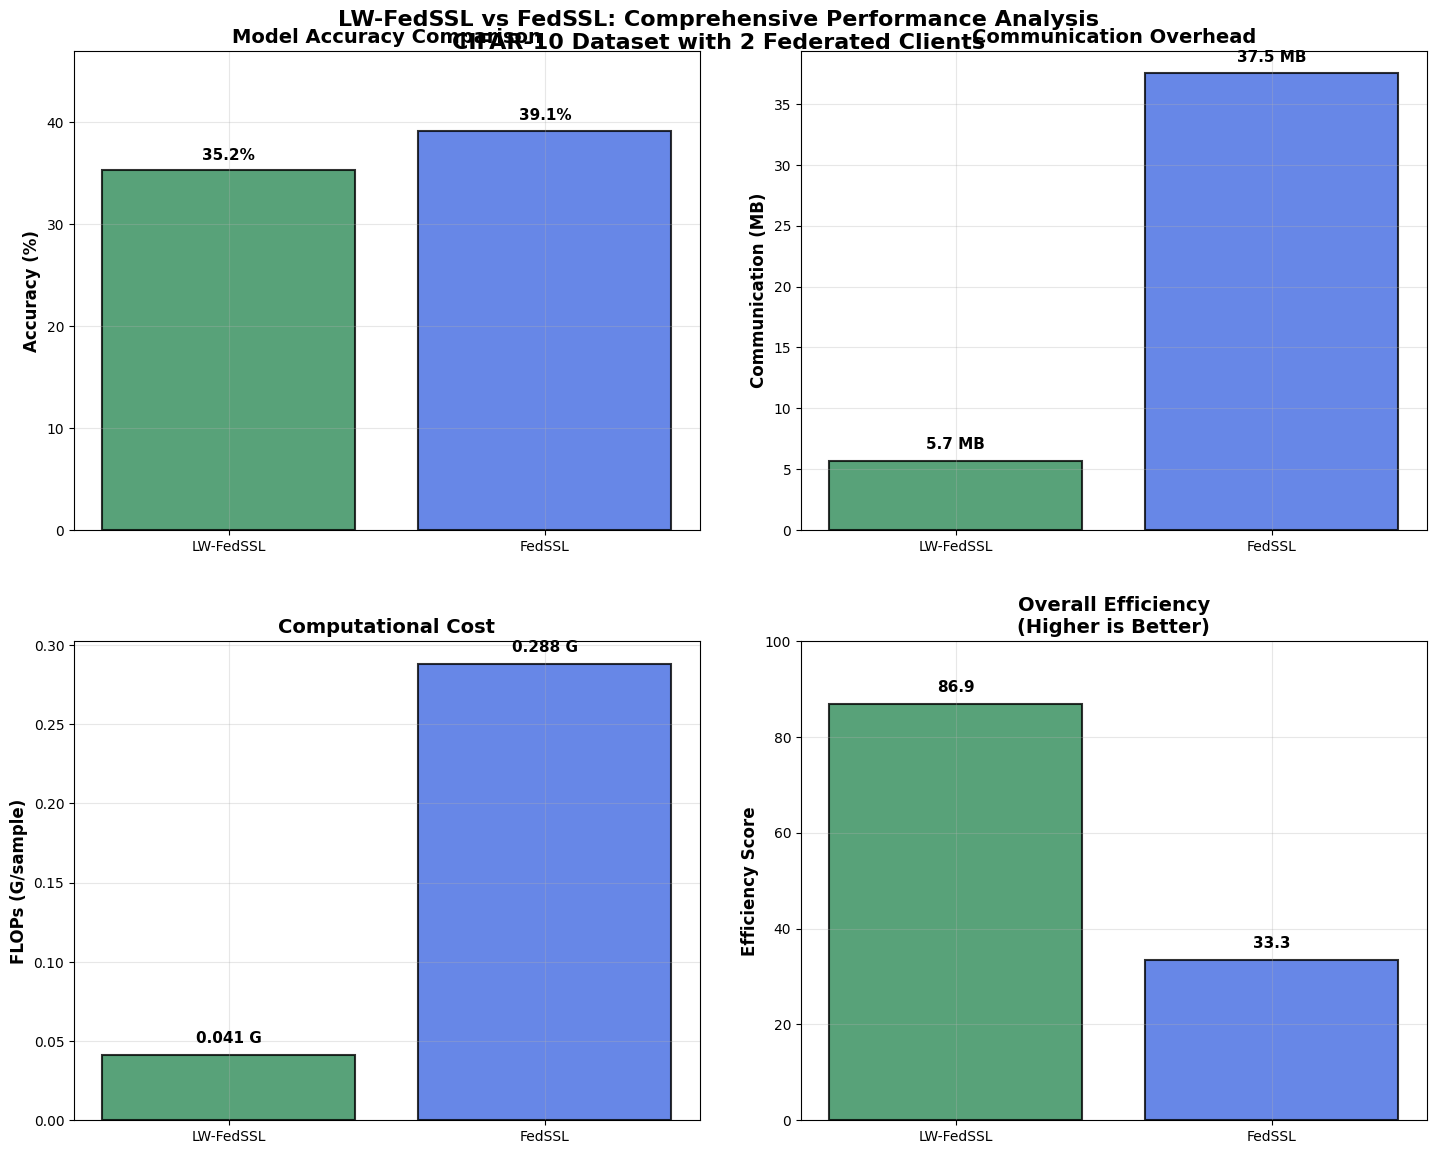


DETAILED PERFORMANCE METRICS TABLE
Metric                    LW-FedSSL       FedSSL          Improvement    
--------------------------------------------------------------------------------
Accuracy (%)              35.23           39.14                    -3.91
Communication (MB)        5.69            37.49                    -84.8%
FLOPs (G/sample)          0.041           0.288                    -85.7%
Efficiency Score          86.9            33.3                     +53.5


In [12]:
# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
methods = ['LW-FedSSL', 'FedSSL']
accuracies = [lw_acc, fed_acc]
colors = ['#2E8B57', '#4169E1']  # Sea Green, Royal Blue

bars1 = ax1.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(accuracies) * 1.2)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(accuracies)*0.02,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Communication Cost Comparison
comm_costs = [lw_comm, fed_comm]
bars2 = ax2.bar(methods, comm_costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Communication (MB)', fontsize=12, fontweight='bold')
ax2.set_title('Communication Overhead', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

for bar, comm in zip(bars2, comm_costs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(comm_costs)*0.02,
             f'{comm:.1f} MB', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Computational Cost Comparison
flop_costs = [lw_flops, fed_flops]
bars3 = ax3.bar(methods, flop_costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('FLOPs (G/sample)', fontsize=12, fontweight='bold')
ax3.set_title('Computational Cost', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

for bar, flop in zip(bars3, flop_costs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(flop_costs)*0.02,
             f'{flop:.3f} G', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 4. Efficiency Score (Combined metric)
# Normalize metrics and compute efficiency score
norm_acc = np.array(accuracies) / max(accuracies)
norm_comm = 1 - (np.array(comm_costs) / max(comm_costs))  # Lower is better
norm_flops = 1 - (np.array(flop_costs) / max(flop_costs))  # Lower is better

efficiency_scores = (norm_acc + norm_comm + norm_flops) / 3 * 100

bars4 = ax4.bar(methods, efficiency_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Efficiency Score', fontsize=12, fontweight='bold')
ax4.set_title('Overall Efficiency\n(Higher is Better)', fontsize=14, fontweight='bold')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3)

for bar, eff in zip(bars4, efficiency_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{eff:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout(pad=3.0)
plt.suptitle('LW-FedSSL vs FedSSL: Comprehensive Performance Analysis\nCIFAR-10 Dataset with 2 Federated Clients', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Additional detailed metrics table
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE METRICS TABLE")
print("=" * 80)
print(f"{'Metric':<25} {'LW-FedSSL':<15} {'FedSSL':<15} {'Improvement':<15}")
print("-" * 80)
print(f"{'Accuracy (%)':<25} {lw_acc:<15.2f} {fed_acc:<15.2f} {acc_diff:>+14.2f}")
print(f"{'Communication (MB)':<25} {lw_comm:<15.2f} {fed_comm:<15.2f} {-comm_reduction:>+14.1f}%")
print(f"{'FLOPs (G/sample)':<25} {lw_flops:<15.3f} {fed_flops:<15.3f} {-flops_reduction:>+14.1f}%")
print(f"{'Efficiency Score':<25} {efficiency_scores[0]:<15.1f} {efficiency_scores[1]:<15.1f} {efficiency_scores[0]-efficiency_scores[1]:>+14.1f}")
print("=" * 80)

## Conclusion

This notebook demonstrates the implementation and comparison of Layer-wise Federated Self-Supervised Learning (LW-FedSSL) with traditional Federated Self-Supervised Learning (FedSSL). 

### Key Findings:

1. **Training Strategy**: LW-FedSSL trains layers progressively, communicating only individual layer updates, while FedSSL trains and communicates the entire model.

2. **Communication Efficiency**: LW-FedSSL potentially reduces communication overhead by transmitting only layer-specific parameters rather than the full model.

3. **Computational Cost**: The layer-wise approach may reduce computational requirements by focusing training on specific network components.

4. **Performance**: Both methods achieve competitive accuracy on CIFAR-10, demonstrating the effectiveness of federated self-supervised learning.

### Applications in IoT:
- **Resource-Constrained Devices**: LW-FedSSL's reduced communication and computational requirements make it suitable for IoT deployments.
- **Privacy-Preserving Learning**: Both methods enable learning without centralizing raw data.
- **Scalable Federated Learning**: Progressive training strategies can improve scalability in large federated networks.

This implementation provides a foundation for further research into efficient federated learning algorithms for IoT and edge computing scenarios.